<a href="https://colab.research.google.com/github/minhtripham9/sarcasm-detection/blob/master/Code/canine_DS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## canine-DS1

### Managing imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm



## Without context

#### Loading dataset 1

In [2]:
# Load the JSONL file (lines=True is key!)
df1 = pd.read_json('Dataset/sarcasm_detection_shared_task_reddit_training.jsonl', lines=True)

# Map label: SARCASM -> 1, NOT_SARCASM -> 0
df1['label'] = df1['label'].replace({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(int)

def get_first_context(context):
    if isinstance(context, list) and context:
        return context[0]
    return context  # in case it's empty or not a list

df1['context'] = df1['context'].apply(get_first_context)
df1


/tmp/ipython-input-3764460506.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['label'] = df1['label'].replace({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(int)


,label,response,context
0,1,"Yeah I mean there's only one gender anyways, w...",LPT: If you're worried about hurting someone's...
1,1,"Sounds like you don't like science, you theist...",Promotional images for some guy's Facebook page
2,1,"Ofc play them in try mode, Blizzard were so ge...",My friends won't play Dota2; I won't play LoL;...
3,1,"I don't understand, Reddit told me that Hillar...",Poll: Convention boosts Clinton to 11-point le...
4,1,"yeh, they're the reigning triple premiers, why...",Wayne Ludbey: Jordan Lewis has the ultimate co...
...,...,...,...
4395,0,well you could've been adulting if you hadn't ...,8-9ft man found in ancient indian burial mound
4396,0,Also they'll have to join the euro,Second Scottish independence referendum 'on th...
4397,0,plot: AI assists a cyborg in freelance investi...,Pinoy Cyborg by James Simmons
4398,0,Some airlines proposed this but too much publi...,The logic here is flawless!


#### Preparing dataset 1

In [3]:
df1['input_text'] = df1['response']

# Check the result
print(df1[['input_text', 'label']].head())

                                          input_text  label
0  Yeah I mean there's only one gender anyways, w...      1
1  Sounds like you don't like science, you theist...      1
2  Ofc play them in try mode, Blizzard were so ge...      1
3  I don't understand, Reddit told me that Hillar...      1
4  yeh, they're the reigning triple premiers, why...      1


In [4]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df1['input_text'], df1['label'],
    test_size=0.2, random_state=42, stratify=df1['label']
)

train_df1 = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df1 = pd.DataFrame({'input_text': X_test, 'label': y_test})


#### Training

In [5]:
train_df1['input_text'] = train_df1['input_text'].fillna("").astype(str)
test_df1['input_text'] = test_df1['input_text'].fillna("").astype(str)

X_train_canine = train_df1['input_text'].tolist()
y_train_canine = train_df1['label'].tolist()
X_test_canine = test_df1['input_text'].tolist()
y_test_canine = test_df1['label'].tolist()

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google/canine-s")

def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,         # You can adjust for your dataset
        return_tensors='pt'
    )

X_train_enc_canine = tokenize(X_train_canine)
X_test_enc_canine = tokenize(X_test_canine)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
train_dataset_canine = TensorDataset(
    X_train_enc_canine['input_ids'],
    X_train_enc_canine['attention_mask'],
    torch.tensor(y_train_canine)
)

test_dataset_canine = TensorDataset(
    X_test_enc_canine['input_ids'],
    X_test_enc_canine['attention_mask'],
    torch.tensor(y_test_canine)
)

In [8]:
batch_size = 16

train_loader = DataLoader(train_dataset_canine, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_canine, batch_size=batch_size)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("google/canine-s", num_labels=2)
model = model.to(device)

Some weights of CanineForSequenceClassification were not initialized from the model checkpoint at google/canine-s and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
optimizer = AdamW(model.parameters(), lr=3e-5)

#### Training loop


In [11]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

model.save_pretrained('canine_no_context')

100%|██████████| 220/220 [01:52<00:00,  1.95it/s]


Epoch 1 Loss: 0.6945


100%|██████████| 220/220 [01:51<00:00,  1.97it/s]


Epoch 2 Loss: 0.6745


100%|██████████| 220/220 [01:51<00:00,  1.98it/s]


Epoch 3 Loss: 0.6325


100%|██████████| 220/220 [01:51<00:00,  1.98it/s]


Epoch 4 Loss: 0.5882


100%|██████████| 220/220 [01:51<00:00,  1.98it/s]


Epoch 5 Loss: 0.5287


#### Evaluation

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained('canine_no_context')
model = model.to(device)

               precision    recall  f1-score   support

Not Sarcastic       0.71      0.46      0.56       440
    Sarcastic       0.60      0.81      0.69       440

     accuracy                           0.64       880
    macro avg       0.65      0.64      0.62       880
 weighted avg       0.65      0.64      0.62       880



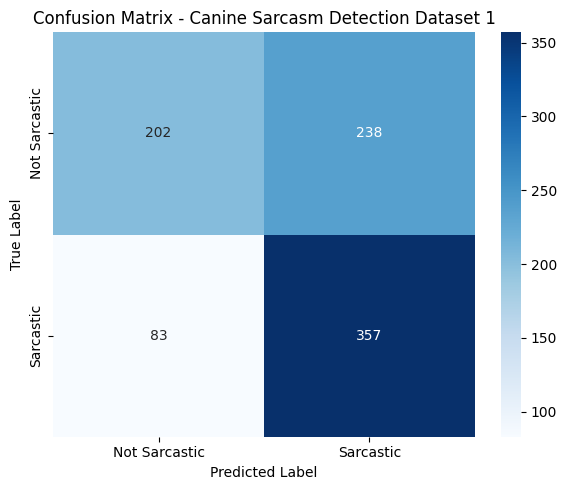

In [26]:
model.eval()
preds_canine, truths_canine = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_canine.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_canine.extend(b_labels.cpu().numpy())

print(classification_report(truths_canine, preds_canine, target_names=['Not Sarcastic', 'Sarcastic']))

cm_canine = confusion_matrix(truths_canine, preds_canine)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_canine, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Canine Sarcasm Detection Dataset 1')
plt.tight_layout()
plt.show()

## With context

#### Loading dataset 1

#### Dataset 1 preparation


In [14]:
df1['input_text'] = df1['response'] + ' [SEP] ' + 'Context :' + df1['context']

# Check the result
print(df1[['input_text', 'label']].head())

                                          input_text  label
0  Yeah I mean there's only one gender anyways, w...      1
1  Sounds like you don't like science, you theist...      1
2  Ofc play them in try mode, Blizzard were so ge...      1
3  I don't understand, Reddit told me that Hillar...      1
4  yeh, they're the reigning triple premiers, why...      1


In [15]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df1['input_text'], df1['label'],
    test_size=0.2, random_state=42, stratify=df1['label']
)

train_df1 = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df1 = pd.DataFrame({'input_text': X_test, 'label': y_test})


#### Training


In [16]:
tokenizer = AutoTokenizer.from_pretrained("google/canine-s")

def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,         # You can adjust for your dataset
        return_tensors='pt'
    )

X_train_enc_canine = tokenize(X_train_canine)
X_test_enc_canine = tokenize(X_test_canine)

In [17]:
train_dataset_canine = TensorDataset(
    X_train_enc_canine['input_ids'],
    X_train_enc_canine['attention_mask'],
    torch.tensor(y_train_canine)
)

test_dataset_canine = TensorDataset(
    X_test_enc_canine['input_ids'],
    X_test_enc_canine['attention_mask'],
    torch.tensor(y_test_canine)
)

In [18]:
batch_size = 16

train_loader = DataLoader(train_dataset_canine, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_canine, batch_size=batch_size)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("google/canine-s", num_labels=2)
model = model.to(device)

Some weights of CanineForSequenceClassification were not initialized from the model checkpoint at google/canine-s and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
optimizer = AdamW(model.parameters(), lr=3e-5)

#### Training loop


In [21]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")
model.save_pretrained('canine_with_context')

100%|██████████| 220/220 [01:51<00:00,  1.98it/s]


Epoch 1 Loss: 0.6944


100%|██████████| 220/220 [01:51<00:00,  1.98it/s]


Epoch 2 Loss: 0.6549


100%|██████████| 220/220 [01:50<00:00,  1.98it/s]


Epoch 3 Loss: 0.6175


100%|██████████| 220/220 [01:50<00:00,  1.98it/s]


Epoch 4 Loss: 0.5706


100%|██████████| 220/220 [01:50<00:00,  1.98it/s]


Epoch 5 Loss: 0.4973


#### Evaluation

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained('canine_with_context')
model = model.to(device)

               precision    recall  f1-score   support

Not Sarcastic       0.64      0.69      0.67       440
    Sarcastic       0.67      0.61      0.64       440

     accuracy                           0.65       880
    macro avg       0.65      0.65      0.65       880
 weighted avg       0.65      0.65      0.65       880



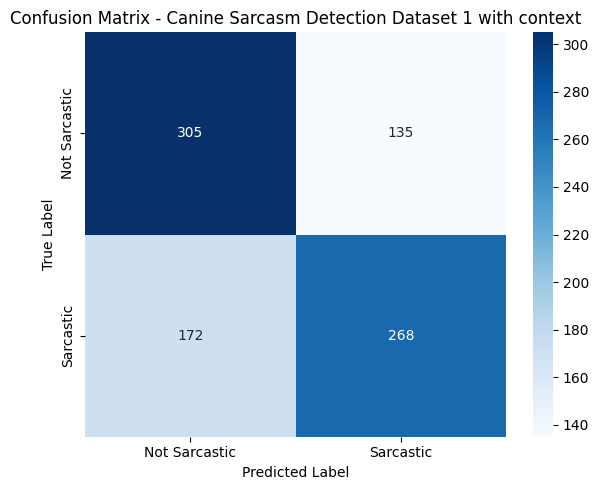

In [28]:
model.eval()
preds_canine, truths_canine = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_canine.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_canine.extend(b_labels.cpu().numpy())

print(classification_report(truths_canine, preds_canine, target_names=['Not Sarcastic', 'Sarcastic']))

cm_canine = confusion_matrix(truths_canine, preds_canine)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_canine, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Canine Sarcasm Detection Dataset 1 with context')
plt.tight_layout()
plt.show()